In [1]:
!git clone https://github.com/shfernan26/Track

fatal: destination path 'Track' already exists and is not an empty directory.


In [2]:
!ls Track

driving_log.csv  IMG


In [3]:
!pip3 install imgaug

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import random
from imgaug import augmenters as iaa

In [5]:
datadir = 'Track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names=columns)
# data = pd.set_option('display.max_colwidth', 1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,S:\Engineering\udacity-self-driving-car-sim\Tr...,S:\Engineering\udacity-self-driving-car-sim\T...,S:\Engineering\udacity-self-driving-car-sim\T...,0.0,0.0,0.0,0.000080
1,S:\Engineering\udacity-self-driving-car-sim\Tr...,S:\Engineering\udacity-self-driving-car-sim\T...,S:\Engineering\udacity-self-driving-car-sim\T...,0.0,0.0,0.0,0.000079
2,S:\Engineering\udacity-self-driving-car-sim\Tr...,S:\Engineering\udacity-self-driving-car-sim\T...,S:\Engineering\udacity-self-driving-car-sim\T...,0.0,0.0,0.0,0.000079
3,S:\Engineering\udacity-self-driving-car-sim\Tr...,S:\Engineering\udacity-self-driving-car-sim\T...,S:\Engineering\udacity-self-driving-car-sim\T...,0.0,0.0,0.0,0.000078
4,S:\Engineering\udacity-self-driving-car-sim\Tr...,S:\Engineering\udacity-self-driving-car-sim\T...,S:\Engineering\udacity-self-driving-car-sim\T...,0.0,0.0,0.0,0.000078


In [6]:
import ntpath

def path_leaf(my_path):
  head, tail = ntpath.split(my_path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2024_04_06_18_53_11_807.jpg,left_2024_04_06_18_53_11_807.jpg,right_2024_04_06_18_53_11_807.jpg,0.0,0.0,0.0,0.000080
1,center_2024_04_06_18_53_11_923.jpg,left_2024_04_06_18_53_11_923.jpg,right_2024_04_06_18_53_11_923.jpg,0.0,0.0,0.0,0.000079
2,center_2024_04_06_18_53_12_026.jpg,left_2024_04_06_18_53_12_026.jpg,right_2024_04_06_18_53_12_026.jpg,0.0,0.0,0.0,0.000079
3,center_2024_04_06_18_53_12_135.jpg,left_2024_04_06_18_53_12_135.jpg,right_2024_04_06_18_53_12_135.jpg,0.0,0.0,0.0,0.000078
4,center_2024_04_06_18_53_12_237.jpg,left_2024_04_06_18_53_12_237.jpg,right_2024_04_06_18_53_12_237.jpg,0.0,0.0,0.0,0.000078


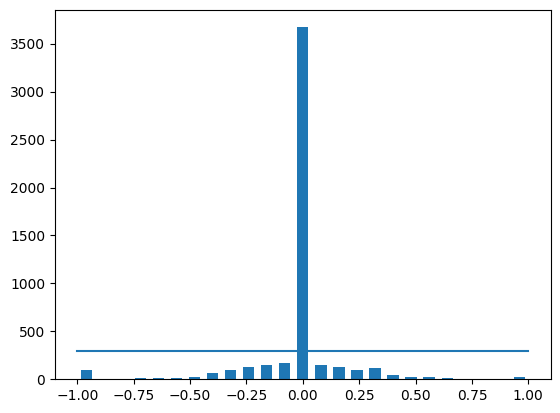

In [7]:
num_bins = 25
samples_per_bin = 300
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data:  5066
removed:  3371
remaining data:  1695


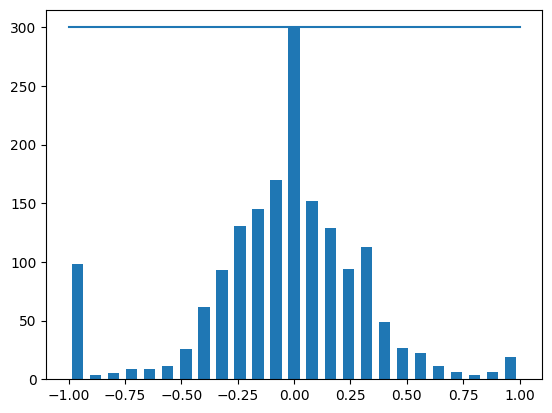

In [8]:
print('total data: ', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_) # shuffle done so that once data is cut the data remaining is not biased
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed: ', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining data: ', len(data))

hist, bin_edges = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin) )


1695
removed:  73
remaining data:  1622


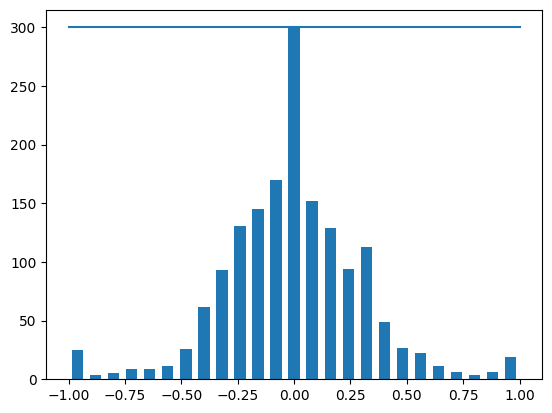

In [9]:
# Added by ME - Need to remove excessive leftmost negative bin
print(len(data))
rem_list2 = [] # another remove list

list_ = []
for i in range(len(data['steering'])):
  if data['steering'].iloc[i] >= bins[0] and data['steering'].iloc[i] <= bins[1]:
    list_.append(i)
list_ = shuffle(list_) # shuffle done so that once data is cut the data remaining is not biased
list_ = list_[25:]
rem_list2.extend(list_)

print('removed: ', len(rem_list2))
data.drop(data.index[rem_list2], inplace=True)
print('remaining data: ', len(data))

hist2, bin_edges = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist2, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin) )

In [10]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right, = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    #left image append
    image_path.append(os.path.join(datadir, left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    #right image append
    image_path.append(os.path.join(datadir, right.strip()))
    steering.append(float(indexed_data[3])-0.15)

  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      center_2024_04_06_18_53_18_572.jpg
left          left_2024_04_06_18_53_18_572.jpg
right        right_2024_04_06_18_53_18_572.jpg
steering                             -0.052989
throttle                                   1.0
reverse                                    0.0
speed                                 3.579843
Name: 61, dtype: object


In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 3892
Valid Samples: 974


Text(0.5, 1.0, 'Validation Set')

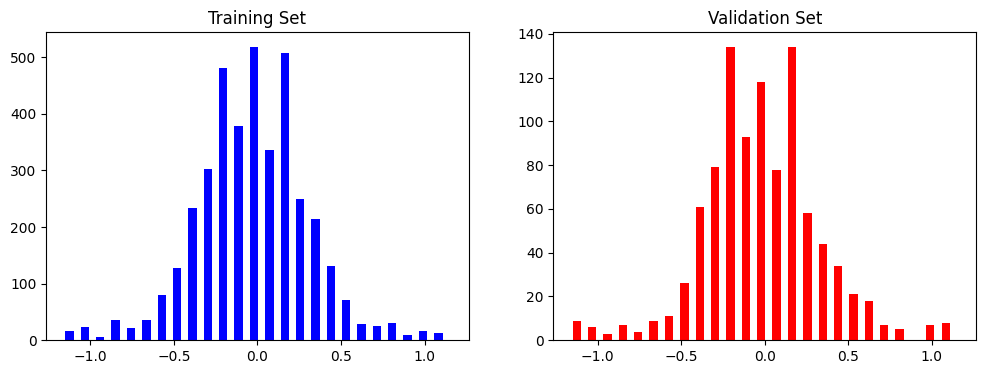

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training Set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation Set')

Image Augmentation section

In [13]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3)) # zoom range from no zoom to 30%
  image = zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'Zoomed Image')

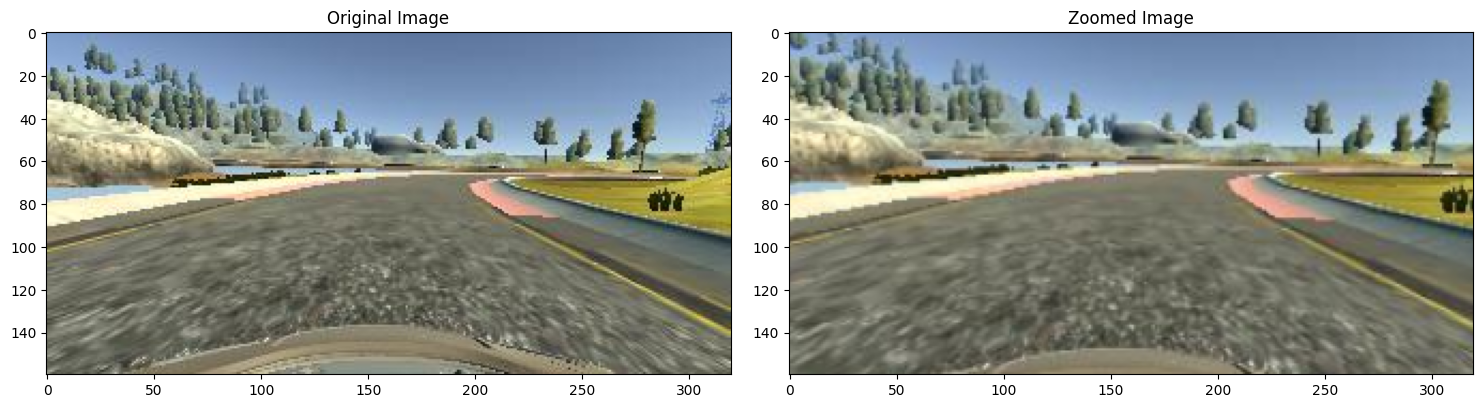

In [14]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

In [15]:
def pan(image):
  pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y":(-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

Text(0.5, 1.0, 'Panned Image')

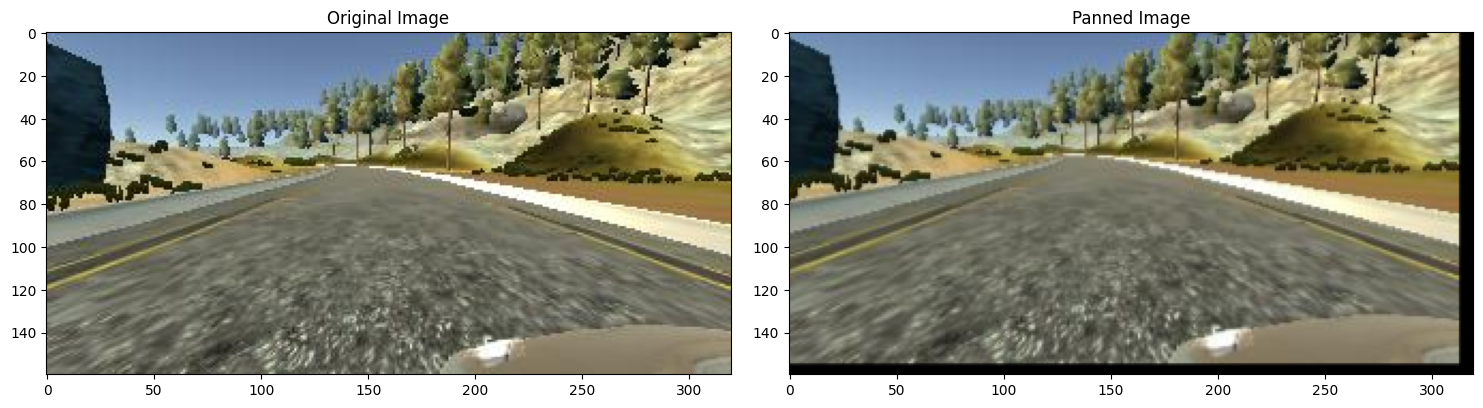

In [16]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

In [17]:
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(image)
  return image

Text(0.5, 1.0, 'Brightness Altered Image')

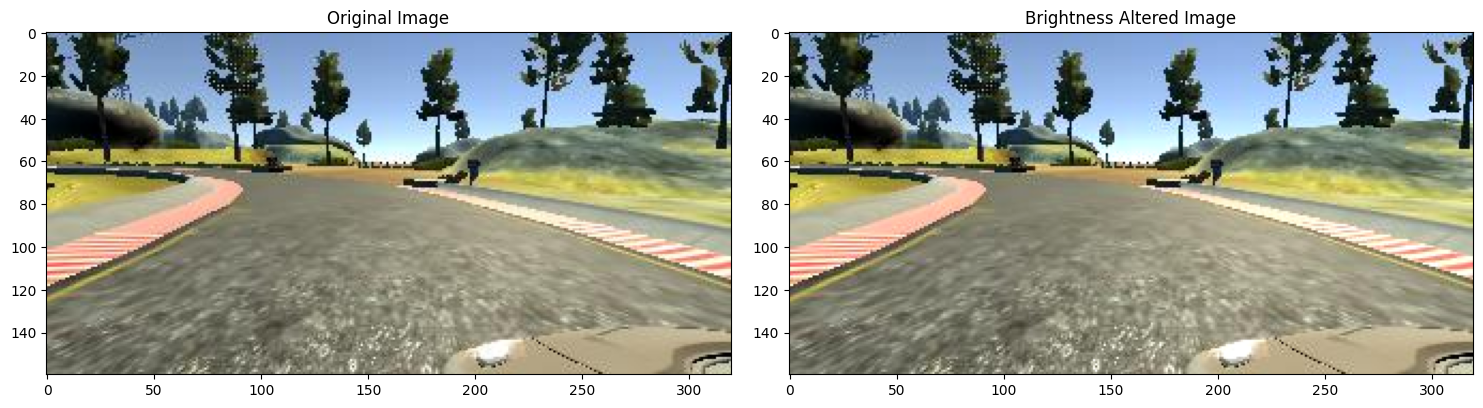

In [18]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness Altered Image')

In [19]:
def img_random_flip(image, steering_angle):
  image = cv2.flip(image, 1) # -1 is horizontal & vertical flip, 1 is just horizontal
  steering_angle = -1*steering_angle
  return image, steering_angle


Text(0.5, 1.0, 'Flipped Image - Steering Angle:0.4379073')

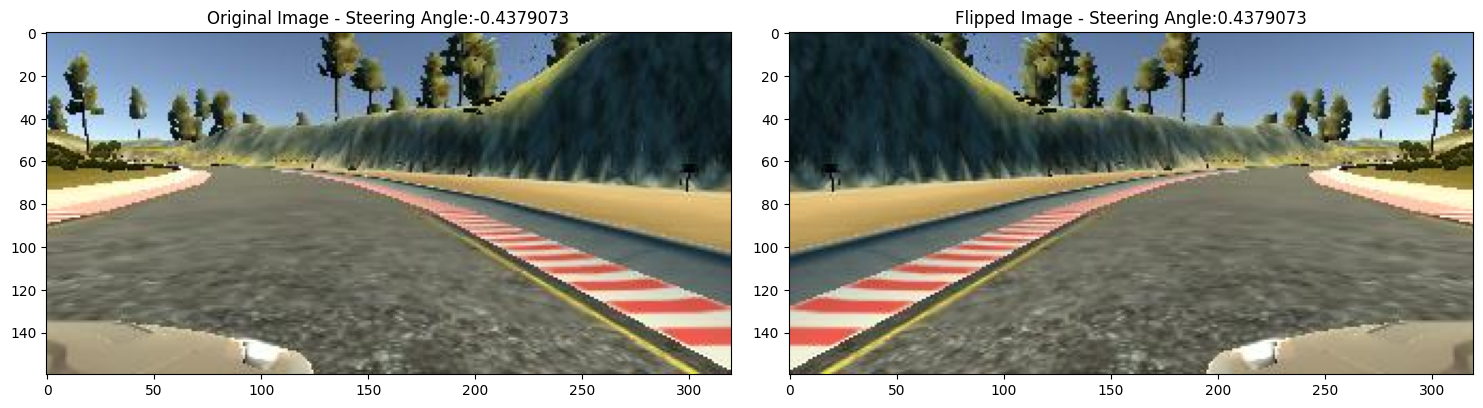

In [20]:
random_index = random.randint(0,1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

In [21]:
def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = img_random_brightness(image)
  if np.random.rand() < 0.5:
    image, steering_angle = img_random_flip(image, steering_angle)

  return image, steering_angle


In [22]:
ncol = 2
nrow = 10
fig, axs = plt.subplots(nrow, ncol, figsize=(15,50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths)-1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]

  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)

  axs[i][0].imshow(original_image)
  axs[i][0].set_title('Original Image')

  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title('Augmented Image')

Output hidden; open in https://colab.research.google.com to view.

Back to normal preprocessing and training code

In [23]:
def img_preprocess(img):
  # img = mpimg.imread(img) --> moved to batch_generator function
  img = img[ 60:135, : , : ] # cropping out top (sky) and bottom (car hood) of image
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV) # color scheme recommended for NVIDIA neural model used later on
  img = cv2.GaussianBlur(img, (3,3), 0) # reduce noise, focus on important features
  img = cv2.resize(img, (200, 66)) # matches input size of images used by NVIDIA model
  img = img/255 # normalize pixel intensities to reduce deviation
  return img

Text(0.5, 1.0, 'Preprocessed Image')

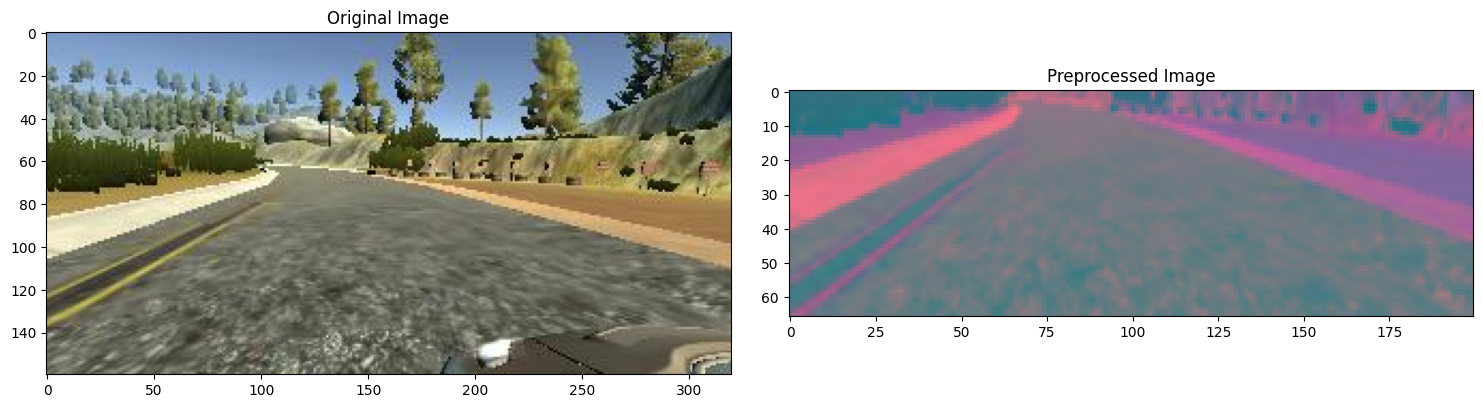

In [24]:
image = image_paths[100]
og_image = mpimg.imread(image)
preprocessed_image = img_preprocess(og_image)

fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(og_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [25]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  # only training data should be augmented, not validation data

  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)

      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]

      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)

    yield (np.asarray(batch_img), np.asarray(batch_steering))

Text(0.5, 1.0, 'Validation Image')

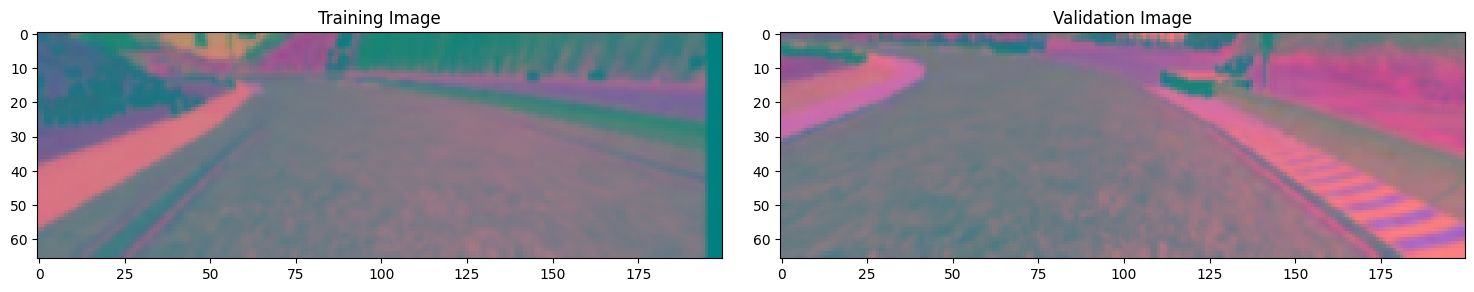

In [26]:
X_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, istraining=True))
X_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, istraining=False))

fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(X_train_gen[0])
axs[0].set_title('Training Image')
axs[1].imshow(X_valid_gen[0])
axs[1].set_title('Validation Image')

In [27]:
# X_train = np.array(list(map(img_preprocess, X_train)))
# X_valid = np.array(list(map(img_preprocess, X_valid)))

In [28]:
# plt.imshow(X_train[random.randint(0, len(X_train)-1)])
# plt.axis('off')
# print(X_train.shape)

In [29]:
def nvidia_model():
  model = Sequential()
  '''
  Changed activation from relu to elu because we were seeing 'dead relu' problem,
  in which 0 gradient of negative portion of relu causes neurons to never learn
  (back propogation uses gradient) if fed in a negative input. This problem causes
  training and validation data to never get close. 'Elu' has a gradually decreasing
  but not completely 0 negative side gradient.
  '''
  model.add(Convolution2D(24, kernel_size=(5, 5), strides=(2,2), input_shape=(66,200,3), activation='elu'))
  model.add(Convolution2D(36, kernel_size=(5, 5), strides=(2,2), activation = 'elu'))
  model.add(Convolution2D(48, kernel_size=(5, 5), strides=(2,2), activation = 'elu'))
  model.add(Convolution2D(64, kernel_size=(3, 3), activation = 'elu'))
  model.add(Convolution2D(64, kernel_size=(3, 3), activation = 'elu'))
  # model.add(Dropout(0.5))

  model.add(Flatten())

  model.add(Dense((100), activation='elu'))
  # model.add(Dropout(0.5))

  model.add(Dense((50), activation='elu'))
  # model.add(Dropout(0.5))

  model.add(Dense((10), activation='elu'))
  # model.add(Dropout(0.5))

  model.add(Dense(1))

  optimizer = Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model


In [30]:
model = nvidia_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 100)               1

In [31]:
# Using fit_generator instead of just fit() since we're creating batches on the fly given the HUUUUGE augmented dataset
# steps per epoch means for each iteration, it will generate batch size that many times (i.e. 300 x 100 per step)
history = model.fit_generator(batch_generator(X_train, y_train, batch_size=100, istraining=True),
                              steps_per_epoch=300,
                              epochs=10,
                              validation_data = batch_generator(X_valid, y_valid, batch_size=100, istraining=False),
                              validation_steps=200,
                              verbose=1,
                              shuffle=1)

<ipython-input-31-047a443a8df1>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(batch_generator(X_train, y_train, batch_size=100, istraining=True),


Epoch 1/10
300/300 [==============================] - 117s 386ms/step - loss: 0.1646 - val_loss: 0.1239
Epoch 2/10
300/300 [==============================] - 112s 373ms/step - loss: 0.0951 - val_loss: 0.0918
Epoch 3/10
300/300 [==============================] - 111s 372ms/step - loss: 0.0883 - val_loss: 0.0972
Epoch 4/10
300/300 [==============================] - 115s 383ms/step - loss: 0.0820 - val_loss: 0.0807
Epoch 5/10
300/300 [==============================] - 114s 381ms/step - loss: 0.0780 - val_loss: 0.0774
Epoch 6/10
300/300 [==============================] - 112s 375ms/step - loss: 0.0745 - val_loss: 0.0731
Epoch 7/10
300/300 [==============================] - 111s 370ms/step - loss: 0.0969 - val_loss: 0.1237
Epoch 8/10
300/300 [==============================] - 96s 320ms/step - loss: 0.0983 - val_loss: 0.1015
Epoch 9/10
300/300 [==============================] - 96s 322ms/step - loss: 0.0821 - val_loss: 0.0810
Epoch 10/10
300/300 [==============================] - 95s 317ms/s

Text(0.5, 0, 'Epoch')

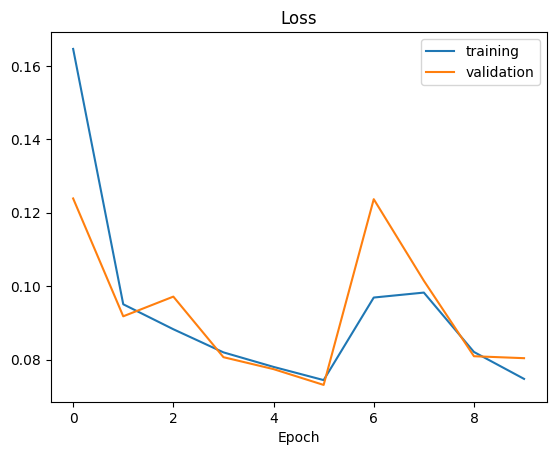

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [33]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [34]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>